In [37]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [38]:
from scipy.stats import beta, multivariate_normal, uniform, norm
from scipy.misc import derivative
import numpy as np
import matplotlib.pyplot as plt
import copy
import pandas as pd

ERROR! Session/line number was not unique in database. History logging moved to new session 36


Use the (local) shape of the distribution to make smarter proposals.

Hamiltonian: quantity that is conserved regardless of position in space.

Metaphor: hockey puck sliding on a (non-flat) surface. Want to be able to describe the state of the puck. The state has two quantities: 

1. Current position, $q$
2. Momentum, $p$

Hamiltonian: $H(q, p) = U(q) + K(p)$

* $U(q)$ -- potential energy
* $K(p)$ -- kinetic energy

In [39]:
dtarget = lambda x: multivariate_normal.pdf(x, mean=(3, 10), cov=[[1, 0], [0, 1]])
x1 = np.linspace(-6, 12, 101)
x2 = np.linspace(-11, 31, 101)
X, Y = np.meshgrid(x1, x2)
Z = np.array(map(dtarget, zip(X.flat, Y.flat))).reshape(101, 101)

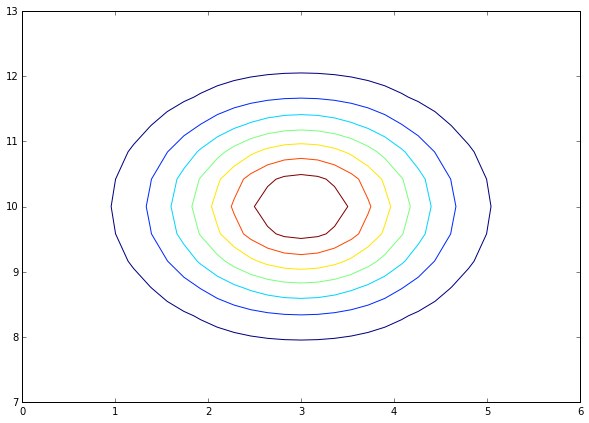

In [40]:
plt.figure(figsize=(10,7))
plt.contour(X, Y, Z)
plt.xlim(0, 6)
plt.ylim(7, 13)
plt.show()

The surface of interest will be $U(q) = -\log{f(q)}$

$K(p) = \frac{p^T p}{2m}$, where $m$ = mass of the puck.

Position over time is a function of momentum: 
$\frac{dq_i}{dt} = \frac{p_i}{m}$

Change in momentum over time is a function of surface gradient:
$\frac{dp_i}{dt} = -\frac{\delta U}{\delta q_i}$

### Leap-frog algorithm

$ p_i(t + \frac{\epsilon}{2}) = p_i(t) - \frac{\epsilon}{2} \frac{\delta U}{\delta q_i} U(q(t))$

$ q_i(t + \epsilon) = q_i(t) + \frac{\epsilon}{m}p_i(t+\frac{\epsilon}{2})$

$ p_i(t + \epsilon) = p_i(t + \frac{\epsilon}{2}) - \frac{\epsilon}{2} \frac{\delta U}{\delta q_i}(q(t+\epsilon))$

$\epsilon$ -- step size

In [41]:
def HMC_one_step(U, current_q, Eps, L, m=1):
    """
    One step of the Hamiltonian Monte Carlo.
    
    Parameters
    ----------
    U : callable
        A function that takes a single argument, the position.
    q : array-like
        Current position.
    Eps : float
        The step size, epsilon.
    L : int
        Number of leapfrog stpes.
    m : float
        Mass of the particle.
        
    Returns
    -------
    q_out : array
        Path from ``q`` to the proposed position.
    """

    q = copy.copy(current_q)
    Nq = len(q)
    p = multivariate_normal.rvs([0. for i in xrange(Nq)])
    current_p = copy.copy(p)

    out = {}
    
    out['p'] = np.zeros((L, Nq))
    out['p'][0,:] = copy.copy(p)
    out['q'] = np.zeros((L, Nq))
    out['q'][0,:] = copy.copy(q)
    
    for i in xrange(1, L):
        p -= Eps*derivative(U, q, 0.01)/2.
        q += (Eps/m)*p
        out['q'][i, :] = copy.copy(q)
        p -= Eps*derivative(U, q, 0.01)/2.
        out['p'][i, :] = copy.copy(p)
    
    current_U = U(current_q)
    current_K = (current_p**2).sum()/2.
    proposed_U = U(q)
    proposed_K = (p**2).sum()/2.
    
    if uniform.rvs() < exp(current_U - proposed_U + current_K - proposed_K):
        out['value'] = q
    else:
        out['value'] = current_q
    
    return out

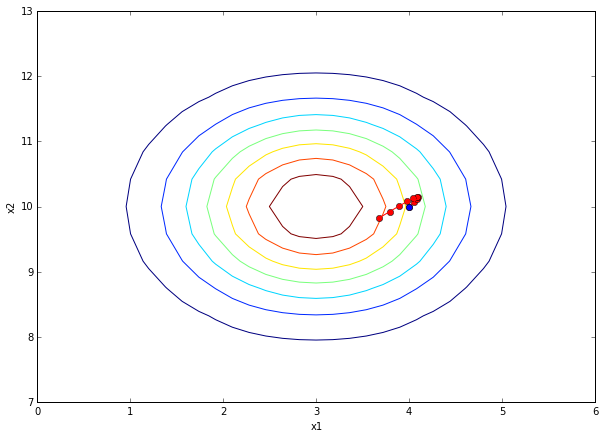

In [42]:
plt.figure(figsize=(10,7))
plt.contour(X, Y, Z)
U = lambda x: -1.*np.log(dtarget(x))
chain = HMC_one_step(U, np.array([4., 10.]), Eps=0.2, L=10, m=2)['q']
plt.plot(chain[:, 0], chain[:, 1], 'ro')
plt.plot(chain[:, 0], chain[:, 1], 'r-')
plt.plot(chain[0, 0], chain[0,1], 'bo')
plt.xlim(0, 6)
plt.ylim(7, 13)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

In [43]:
def HMC(dtarget, start, Eps=0.2, L=10, m=2, N=1000, num_chains=4):
    """
    Perform an HMC simulation.
    
    Parameters
    ----------
    dtarget : callable
        Target PDF.
    
    """
    
    # Invert the target PDF into a concave surface.
    neg_log_dtarget = lambda x: -1.*np.log(dtarget(x))
    
    # If only one starting position is provided, use it for all chains.
    if len(start.shape) == 1:
        start = np.array([np.array(start) for i in xrange(num_chains)])
        
    chains = []
    for j in xrange(num_chains):
        chain = [start[j, :]]
        for i in xrange(N):
            proposal = HMC_one_step(neg_log_dtarget, 
                                    copy.copy(chain[-1]), 
                                    Eps, L, m)['value']
            chain.append(proposal)
        chains.append(np.array(chain))
    return np.array(chains)        

Tuning parameters: step size, number of steps, and "mass" 

HMC does not work discrete parameters. STAN is all HMC.

Gelman metric still applies -- we just have a better way of proposing values.

In [44]:
def Gelman(chains):
    if len(chains.shape) == 3:
        N_p = chains.shape[2]
    else:
        N_p = 1
    generate = lambda ptn: np.array([np.array([np.array([ptn(p, i, c) 
                                                         for p in xrange(N_p)
                                               for i in xrange(chains.shape[1])])
                                     for c in xrange(chains.shape[0])])])
    params = generate(lambda p, i, c: 'x{0}'.format(p))
    iters = generate(lambda p, i, c: i)
    labels = generate(lambda p, i, c: c)
                      
    data = zip(chains.flat, params.flat, iters.flat, labels.flat)
    dataframe = pd.DataFrame(data, columns=('Value', 'Parameter', 'Iteration', 'Chain'))

    xbar = dataframe.groupby('Parameter').Value.mean()
    m = chains.shape[0]
    xbar_i = dataframe.groupby(('Parameter', 'Chain')).Value.mean()
    s2_i = dataframe.groupby(('Parameter', 'Chain')).Value.var()
    n = dataframe.groupby(('Parameter', 'Chain')).Value.count().mean()

    W = s2_i.mean()
    B = (n/(m-1.)) * ((xbar_i - xbar)**2).sum()
    sigma2_hat = W*(n-1.)/n + B/n
    R_hat = np.sqrt(sigma2_hat/W)
    n_eff = m*n*sigma2_hat/B    # I missed what this was for.
                      
    return R_hat, n_eff

In [45]:
chains = HMC(dtarget, array([4., 10.]), Eps=0.2, L=5, N=1000)

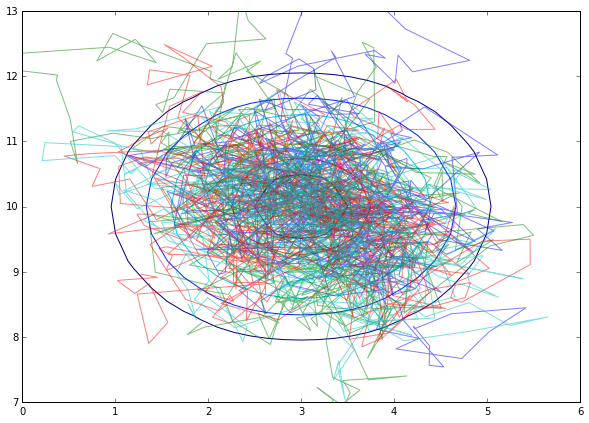

In [46]:
plt.figure(figsize=(10,7))
plt.contour(X, Y, Z)
plt.plot(chains[0][:, 0], chains[0][:, 1], alpha=0.5)
plt.plot(chains[1][:, 0], chains[1][:, 1], alpha=0.5)
plt.plot(chains[2][:, 0], chains[2][:, 1], alpha=0.5)
plt.plot(chains[3][:, 0], chains[3][:, 1], alpha=0.5)
plt.xlim(0, 6)
plt.ylim(7, 13)
plt.show()

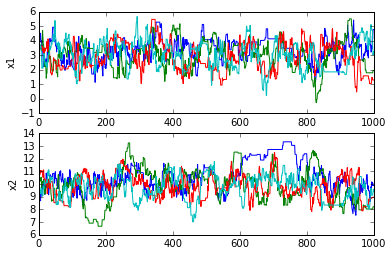

In [47]:
plt.subplot(211)
for i in xrange(chains.shape[0]):
    plt.plot(chains[i,:,0])
plt.ylabel('x1')

plt.subplot(212)
for i in xrange(chains.shape[0]):
    plt.plot(chains[i,:,1])
plt.ylabel('x2')

In [48]:
Gelman(chains)

(1.0079758886063845, 238.8602147287925)

### Banana-shaped target distribution

In [49]:
dtarget = lambda x: exp( (-x[0]**2)/200. - 0.5*(x[1]+(0.05*x[0]**2) - 100.*0.05)**2)

In [50]:
x1 = np.linspace(-20, 20, 101)
x2 = np.linspace(-15, 10, 101)
X, Y = np.meshgrid(x1, x2)
Z = np.array(map(dtarget, zip(X.flat, Y.flat))).reshape(101, 101)

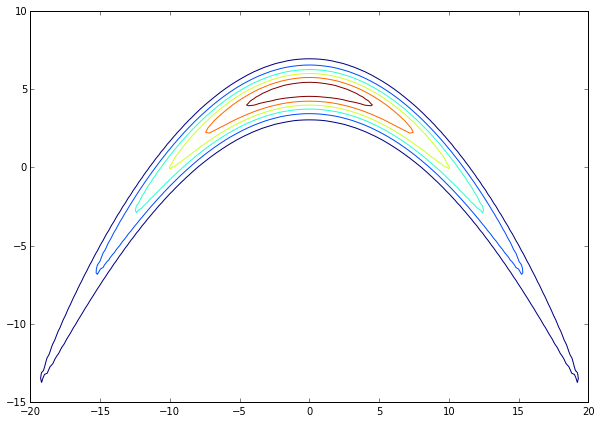

In [51]:
plt.figure(figsize=(10,7))
plt.contour(X, Y, Z)
plt.show()

In [65]:
start = np.array([[2., 5.]
                  for i in xrange(4)])
chains = HMC(dtarget, start, Eps=0.5, L=200, m=0.5, N=5000)

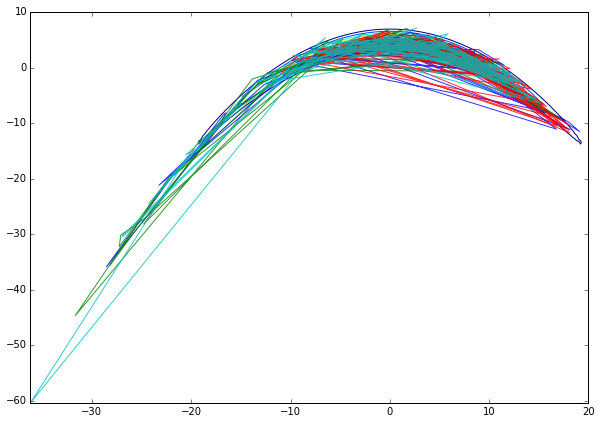

In [66]:
plt.figure(figsize=(10,7))
plt.contour(X, Y, Z)

plt.plot(chains[0][:, 0], chains[0][:, 1], alpha=0.8)
plt.plot(chains[1][:, 0], chains[1][:, 1], alpha=0.8)
plt.plot(chains[2][:, 0], chains[2][:, 1], alpha=0.8)
plt.plot(chains[3][:, 0], chains[3][:, 1], alpha=0.8)
plt.show()

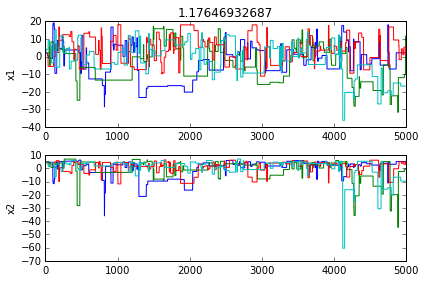

In [67]:
plt.subplot(211)
plt.title(Gelman(chains)[0])
for i in xrange(chains.shape[0]):
    plt.plot(chains[i,:,0])
plt.ylabel('x1')

plt.subplot(212)
for i in xrange(chains.shape[0]):
    plt.plot(chains[i,:,1])
plt.ylabel('x2')

plt.tight_layout()
plt.show()

## NUTS Sampler

Toy implementation of No-U-Turn Sampler, described by [Hoffman and Gelman (2011)](http://arxiv.org/pdf/1111.4246v1.pdf). Algorithm 3, page 14.

In [19]:
def Leapfrog(U, theta, r, Eps, m=1.):
    """
    Slightly different update rules, since the negative log of the 
    target PDF is not used.
    """
    gradient = lambda U, theta: derivative(U, theta, 0.01)
    r += (Eps/2.)*gradient(U, theta)
    theta += (Eps/m)*r
    r += (Eps/2.)*gradient(U, theta)
    return copy.copy(theta), copy.copy(r)

In [20]:
def BuildTree(U, theta, r, u, v, j, Eps, m=1., delta_max=1000):
    """
    Recursive tree-building.
    
    TODO: Make this less ugly.
    """
    if j == 0:
        # Take one leapfrog step in the direction v.
        theta_p, r_p = Leapfrog(U, theta, r, v*Eps, m=m)
        n_p = float(u <= exp(U(theta_p) - np.dot(0.5*r_p, r_p)))
        s_p = float(u < exp(delta_max + U(theta_p) - np.dot(0.5*r_p, r_p)))
        return theta_p, r_p, theta_p, r_p, theta_p, n_p, s_p
    else:
        # Recursion -- implicitly build the left and right subtrees.
        rargs = (u, v, j-1., Eps)
        rkwargs = {'m':m}
        theta_n, r_n, theta_f, r_f, theta_p, n_p, s_p = BuildTree(U, theta, r, *rargs, **rkwargs)
        if s_p == 1:
            if v == -1:
                theta_n, r_n, null, null, theta_dp, n_dp, s_dp = BuildTree(U, theta_n, r_n, *rargs, **rkwargs)
            else:
                null, null, theta_f, r_f, theta_dp, n_dp, s_dp = BuildTree(U, theta_f, r_f, *rargs, **rkwargs)
            try:
                if uniform.rvs() <= (n_dp/(n_p + n_dp)):
                    theta_p = copy.copy(theta_dp)
            except ZeroDivisionError:
                pass
            s_p = s_p*s_dp*int(np.dot((theta_f - theta_n), r_n) >= 0)*int( np.dot((theta_f - theta_n), r_f) >= 0)
            n_p += n_dp
        return theta_n, r_n, theta_f, r_f, theta_p, n_p, s_p

In [21]:
def NUTS_one_step(U, theta_last, Eps, m=1.):
    """
    TODO: clean up all the copies -- stop being so paranoid.
    """
    r_not = norm.rvs(0, 1., size=len(theta_last))
    u = uniform.rvs(0, exp(U(theta_last) - np.dot(0.5*r_not, r_not)))
    
    # Initialize.
    theta_m = copy.copy(theta_last)
    theta_n, theta_f = copy.copy(theta_last), copy.copy(theta_last)
    r_n, r_f = copy.copy(r_not), copy.copy(r_not)
    j = 0.
    s = 1.
    n = 1.

    while s == 1.:
        v_j = np.random.choice(np.array([-1., 1.]))    # Choose a direction.
        if v_j == -1:
            theta_n, r_n, null, null, theta_p, n_p, s_p = BuildTree(U, theta_n, r_n, u, v_j, j, Eps, m=m)
        else:
            null, null, theta_f, r_f, theta_p, n_p, s_p = BuildTree(U, theta_f, r_f, u, v_j, j, Eps, m=m)

        if s_p == 1:
            try:
                if uniform.rvs() <= min(1., (n_p/n)):
                    theta_m = copy.copy(theta_p)
            except ZeroDivisionError:
                pass
        s = s_p*int(np.dot((theta_f - theta_n), r_n) >= 0)*int( np.dot((theta_f - theta_n), r_f) >= 0)
        j += 1.

    return theta_m

In [22]:
NUTS_one_step(lambda x: np.log(dtarget(x)), np.array([3.2, 9.1]), 0.02)

array([ 3.2124508 ,  9.13756381])

In [23]:
def NUTS(dtarget, theta_not, Eps, num_iters=1000, delta_max=1000, m=1.):
    U = lambda x: np.log(dtarget(x))
    
    theta = [theta_not]
    for i in xrange(num_iters):
        theta_i = NUTS_one_step(U, theta[-1], Eps, m=m)
        theta.append(theta_i)
    return theta

### Testing on the banana

In [24]:
start = np.array([[uniform.rvs(loc=-10., scale=15.), 
                   uniform.rvs(loc=0., scale=10)]
                  for i in xrange(4)])

In [34]:
chains = np.array([ np.array(NUTS(dtarget, start[i, :], Eps=0.55, m=1.5, num_iters=10000)) for i in xrange(start.shape[0])])

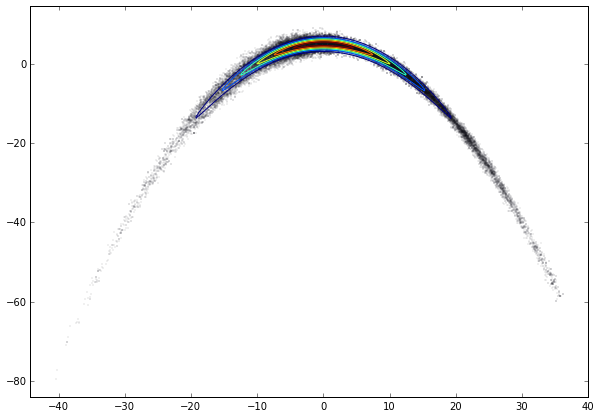

In [35]:
plt.figure(figsize=(10,7))
plt.contour(X, Y, Z)

for i in xrange(chains.shape[0]):
    plt.scatter(chains[i, :, 0], chains[i, :, 1], alpha=0.5, s=0.02)
plt.show()

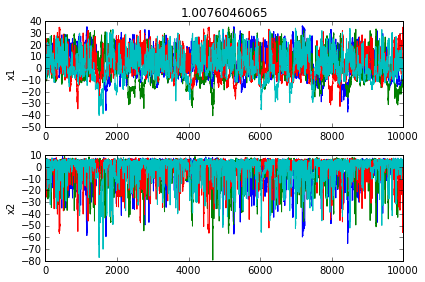

In [36]:
plt.subplot(211)
plt.title(Gelman(chains)[0])
for i in xrange(chains.shape[0]):
    plt.plot(chains[i, :, 0])
plt.ylabel('x1')

plt.subplot(212)
for i in xrange(chains.shape[0]):
    plt.plot(chains[i, :, 1])
plt.ylabel('x2')

plt.tight_layout()
plt.show()

In [ ]:
plt.hist(chains[0,:,0])